In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.constants
import time as time

In [35]:
neutrons_number = 50  # low number for the sake of testing the code, should be set to 5000 in an actual simulation
height = 6000  # reactor height in cm, kept constant in this simulation
radius = 220  # starting reactor radius, cm
radius_step = 5  # reactor radius increment, cm
trials = 15  # number of radius trials
iterations = 10  # stages of particle behaviour within each trial, should be set to 100

In [3]:
Na = scipy.constants.Avogadro # avogadro's number
Barn = 10**-24 # barns in cm^-2
v = 2.42

U_density = 18.9 *(1/300)
C_density = 1.67 *(299/300)
U235_Mr = 235 # 238.02891
U238_Mr = 238
C_Mr = 12
U235_p = 0.725*0.01 # concentration of uranium 235
U238_p = 1-U235_p

U235_c = 101 # microscopic cross section of capture of uranium  in barns
U238_c = 2.72
C_c    = 0.0035
U235_f = 579 # fission
U235_s = 10  # scattering
U238_s = 8.3
C_s    = 5.551


U235_Ec = (U_density * U235_p * U235_c * Barn * Na)/(U235_Mr) # macroscopic cross section of capture of 235
U238_Ec = (U_density * U238_p * U238_c * Barn * Na)/(U238_Mr)
C_Ec    = (C_density * C_c * Barn * Na)/(C_Mr)
U235_Ef = (U_density * U235_p * U235_f * Barn * Na)/(U235_Mr) # fission
U235_Es = (U_density * U235_p * U235_s * Barn * Na)/(U235_Mr) # scattering
U238_Es = (U_density * U238_p * U238_s * Barn * Na)/(U238_Mr)
C_Es    = (C_density * C_s * Barn * Na)/(C_Mr)

Ec = U235_Ec + U238_Ec + C_Ec
Ef = U235_Ef
Es = U235_Es + U238_Es + C_Es
Et = Ec+Ef+Es
lamb = 1/Et

p_a = (Ef+Ec)/Et
p_f = Ef/(Ef+Ec)

v_eff = v*p_f


In [10]:
def scatter(N, H, R):

    theta = np.random.uniform(0,2*np.pi, N)
    rad = np.random.uniform(0, R**2, N)
    X = np.sqrt(rad)*np.cos(theta)
    Y = np.sqrt(rad)*np.sin(theta)
    Z = np.random.uniform(0, H, N)
    return X,Y,Z

def central_scatter(N,H):

    z = np.random.uniform(0,H,N)
    x=0
    y=0

    return x,y,z

def random_direction():
    theta = np.random.uniform(0, 2*np.pi, 1)
    r = np.random.uniform(0, 1, 1)
    phi = np.arccos(2*r-1)
    return theta, phi

def random_length(lamb):
    r = np.random.uniform(0,1,1)
    d = -lamb*np.log(r)
    return d

def outcome_decider(p):
    r = np.random.uniform(0,1,1)
    if r <= p :
        return True
    else :
        return False

def random_motion(lamb,pos):
    L = random_length(lamb)
    theta, phi = random_direction()

    pos[0] = pos[0] + L*np.cos(theta)*np.sin(phi)
    pos[1] = pos[1] + L*np.sin(theta)*np.sin(phi)
    pos[2] = pos[2] + L*np.cos(phi)
    return pos

def resolution(pos):
    stopped = False


    result = np.array([0,0,0,0]) # escaped,bounced,captured, v_eff
    while stopped == False:


        pos = random_motion(lamb,pos)


        if (pos[0]**2 + pos[1]**2 < radius**2  and pos[2]>0 and pos[2]<height) == False:
            stopped = True
            result = result + [1,0,0,0]
        elif outcome_decider(p_a) == True :
            result = result + [0,0,1,v_eff]
            stopped = True
        else:
            result = result + [0,1,0,0]

    return result, pos

def resampler(absorbed):
    posistion = np.zeros((neutrons_number,3))
    for i in range(neutrons_number):
        j = np.random.randint(0,len(absorbed))
        posistion[i] = absorbed[j]
    return posistion

In [36]:
iteration = 0
trial = 0

escaped_total = np.empty((1,iterations))
absorb_total = np.empty((1,iterations))
radius_total = np.empty((1,iterations))
height_total = np.empty((1,iterations))
k_total = np.empty((1,iterations))

for trial in range(trials):
    print('\n\nHeight : {}    Radius : {}'.format(height, radius))

    k_array = []
    escaped_array = []
    absorb_counter = []
    radius_array = []
    height_array = []
    result_array = np.zeros((neutrons_number,4)) # escaped,bounced,absorbed, v_eff
    iteration = 0

    x,y,z = scatter(neutrons_number, height, radius)
    posistion_array = np.column_stack((x,y,z))

    for j in range(iterations):

        absorbed_array = np.empty((0,3))

        for i in range(neutrons_number):

            result, temp = resolution(posistion_array[i])
            result_array[i] = result

            if result[2] == 1:
                absorbed_array = np.vstack((absorbed_array, temp))

        split = np.hsplit(result_array,4)

        k = np.sum(split[3])/neutrons_number  # k-value, or the multiplication factor
        iteration = iteration + 1
        print("\nTrial : {0}    Iteration : {1}".format(trial, iteration))
        print("K value : {0:4.3f}    Escaped : {1}    Absorbed : {2}    ".format(k, np.sum(split[0]), np.sum(split[2])))


        k_array = np.append(k_array, k)
        escaped_array = np.append(escaped_array, np.sum(split[0]))
        absorb_counter = np.append(absorb_counter, np.sum(split[2]))
        radius_array = np.append(radius_array, radius)
        height_array = np.append(height_array, height)


        posistion_array = resampler(absorbed_array)

    escaped_total = np.vstack((escaped_total, escaped_array))
    absorb_total = np.vstack((absorb_total, absorb_counter))
    radius_total = np.vstack((radius_total, radius_array))
    height_total = np.vstack((height_total, height_array))
    k_total = np.vstack((k_total, k_array))


    radius = radius + radius_step
    trial = trial + 1



Height : 6000    Radius : 220


/tmp/ipython-input-403329871.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pos[0] = pos[0] + L*np.cos(theta)*np.sin(phi)
/tmp/ipython-input-403329871.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pos[1] = pos[1] + L*np.sin(theta)*np.sin(phi)
/tmp/ipython-input-403329871.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pos[2] = pos[2] + L*np.cos(phi)



Trial : 0    Iteration : 1
K value : 0.778    Escaped : 14.0    Absorbed : 36.0    

Trial : 0    Iteration : 2
K value : 0.993    Escaped : 4.0    Absorbed : 46.0    

Trial : 0    Iteration : 3
K value : 0.929    Escaped : 7.0    Absorbed : 43.0    

Trial : 0    Iteration : 4
K value : 0.929    Escaped : 7.0    Absorbed : 43.0    

Trial : 0    Iteration : 5
K value : 1.015    Escaped : 3.0    Absorbed : 47.0    

Trial : 0    Iteration : 6
K value : 0.950    Escaped : 6.0    Absorbed : 44.0    

Trial : 0    Iteration : 7
K value : 0.993    Escaped : 4.0    Absorbed : 46.0    

Trial : 0    Iteration : 8
K value : 0.993    Escaped : 4.0    Absorbed : 46.0    

Trial : 0    Iteration : 9
K value : 1.058    Escaped : 1.0    Absorbed : 49.0    

Trial : 0    Iteration : 10
K value : 1.015    Escaped : 3.0    Absorbed : 47.0    


Height : 6000    Radius : 225

Trial : 1    Iteration : 1
K value : 0.886    Escaped : 9.0    Absorbed : 41.0    

Trial : 1    Iteration : 2
K value : 0.88

In [37]:
N = 20  # number of iterations to keep from the end for final analysis

trial_k_values = np.vsplit(k_total, len(k_total))

final_k_values = []
for trial in trial_k_values:
    values = trial[0]
    n_keep = min(N, len(values))
    final_k_values.append(values[-n_keep:])

mean_k_per_trial = np.array([np.mean(arr) for arr in final_k_values[1:]])
std_k_per_trial  = np.array([np.std(arr)  for arr in final_k_values[1:]])


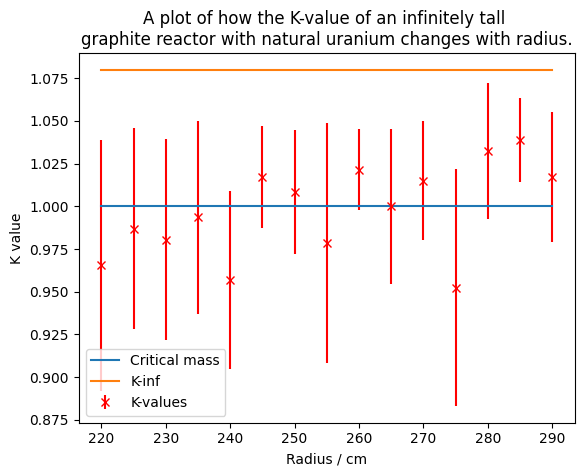

In [40]:
trial_radii = np.vsplit(radius_total, len(radius_total))
radii_per_trial = np.array([trial[0][0] for trial in trial_radii[1:]])

x_vals = radii_per_trial
y_vals = mean_k_per_trial
y_errs = std_k_per_trial

line_x = [x_vals[0], x_vals[-1]]
line_y_1 = [1, 1]
line_y_veff = [v_eff, v_eff]

plt.errorbar(x_vals,y_vals,yerr=y_errs, fmt='rx', label = 'K-values')
plt.plot(line_x,line_y_1, label = 'Critical mass')
plt.plot(line_x,line_y_veff, label = 'K-inf')

plt.title('A plot of how the K-value of an infinitely tall \ngraphite reactor with natural uranium changes with radius.')
plt.xlabel('Radius / cm')
plt.ylabel('K value')
plt.legend()
# plt.savefig('Radius.png', dpi = 600)
plt.show()